# In-Situ Validation Analysis

Aggregate and visualize in-situ validation results from the Lake CCI gap-filling pipeline.

**Author:** Shaerdan / NCEO / University of Reading  
**Date:** December 2024

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from pathlib import Path

# Plot settings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

%matplotlib inline

## 2. Configuration

**Edit these paths for your experiment:**

In [2]:
# ============== EDIT THIS ==============
RUN_ROOT = "/gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/anomaly-20251215-8ea02d-exp3"
OUTPUT_DIR = None  # Set to a path, or None to use {RUN_ROOT}/insitu_analysis
# =======================================

# Resolve output directory
if OUTPUT_DIR is None:
    OUTPUT_DIR = os.path.join(RUN_ROOT, "insitu_analysis")

os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Run root:   {RUN_ROOT}")
print(f"Output dir: {OUTPUT_DIR}")

Run root:   /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/anomaly-20251215-8ea02d-exp3
Output dir: /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/anomaly-20251215-8ea02d-exp3/insitu_analysis


## 3. Find and Load In-Situ CSV Files

In [3]:
def find_insitu_csvs(run_root: str):
    """
    Find all in-situ validation CSV files.
    Pattern: {run_root}/post/{lake_id}/a1000/insitu_cv_validation/LAKE*_insitu_stats_*.csv
    """
    post_dir = Path(run_root) / "post"
    if not post_dir.exists():
        print(f"Post directory not found: {post_dir}")
        return []
    
    csvs = []
    for lake_dir in post_dir.iterdir():
        if not lake_dir.is_dir():
            continue
        
        for alpha_dir in lake_dir.iterdir():
            if not alpha_dir.is_dir() or not alpha_dir.name.startswith("a"):
                continue
            
            insitu_dir = alpha_dir / "insitu_cv_validation"
            if insitu_dir.exists():
                csvs.extend(insitu_dir.glob("LAKE*_insitu_stats_*.csv"))
    
    return sorted(csvs)

# Find files
csv_files = find_insitu_csvs(RUN_ROOT)
print(f"Found {len(csv_files)} in-situ CSV files")

if csv_files:
    print("\nFirst 5 files:")
    for f in csv_files[:5]:
        print(f"  {f}")

Found 86 in-situ CSV files

First 5 files:
  /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/anomaly-20251215-8ea02d-exp3/post/000000020/a1000/insitu_cv_validation/LAKE000000020_insitu_stats_site1.0.csv
  /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/anomaly-20251215-8ea02d-exp3/post/000000020/a1000/insitu_cv_validation/LAKE000000020_insitu_stats_yearly_site1.0.csv
  /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/anomaly-20251215-8ea02d-exp3/post/000000044/a1000/insitu_cv_validation/LAKE000000044_insitu_stats_site1.0.csv
  /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/anomaly-20251215-8ea02d-exp3/post/000000044/a1000/insitu_cv_validation/LAKE000000044_insitu_stats_yearly_site1.0.csv
  /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/anomaly-20251215-8ea02d-exp3/post/000000052/a1000/insitu_cv_validation/LAKE000000052_insitu_stats_site1.0.csv


In [4]:
def load_all_insitu_results(csv_files):
    """Load all in-situ CSV files into one DataFrame."""
    all_dfs = []
    
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            df['source_file'] = csv_file.name
            all_dfs.append(df)
        except Exception as e:
            print(f"Warning: Could not read {csv_file}: {e}")
    
    if not all_dfs:
        return pd.DataFrame()
    
    return pd.concat(all_dfs, ignore_index=True)

# Load data
df = load_all_insitu_results(csv_files)
print(f"Loaded {len(df)} rows from {len(csv_files)} files")
print(f"\nUnique lakes: {df['lake_id'].nunique()}")
print(f"Methods: {df['method'].unique().tolist()}")
print(f"Data types: {df['data_type'].unique().tolist()}")

Loaded 5076 rows from 86 files

Unique lakes: 24
Methods: ['dineof', 'dincae', 'eof_filtered', 'interp_full', 'eof_filtered_interp_full']
Data types: ['observation', 'reconstruction']


In [5]:
# Preview the data
df.head(10)

,lake_id,lake_id_cci,site_id,method,data_type,n_matches,rmse,mae,bias,median,std,rstd,correlation,source_file,year
0,20.0,20,1.0,dineof,observation,299,1.264219,0.912911,-0.818664,-0.689987,0.964962,0.700511,0.851885,LAKE000000020_insitu_stats_site1.0.csv,NaN
1,20.0,20,1.0,dineof,reconstruction,409,0.908695,0.759400,-0.622124,-0.655553,0.663147,0.662175,0.918630,LAKE000000020_insitu_stats_site1.0.csv,NaN
2,20.0,20,1.0,dincae,observation,299,1.264219,0.912911,-0.818664,-0.689987,0.964962,0.700511,0.851885,LAKE000000020_insitu_stats_site1.0.csv,NaN
3,20.0,20,1.0,dincae,reconstruction,409,0.931527,0.764378,-0.638993,-0.649252,0.678643,0.671629,0.919676,LAKE000000020_insitu_stats_site1.0.csv,NaN
4,20.0,20,1.0,eof_filtered,observation,299,1.264219,0.912911,-0.818664,-0.689987,0.964962,0.700511,0.851885,LAKE000000020_insitu_stats_site1.0.csv,NaN
5,20.0,20,1.0,eof_filtered,reconstruction,409,0.908697,0.759402,-0.622126,-0.655553,0.663147,0.662152,0.918630,LAKE000000020_insitu_stats_site1.0.csv,NaN
6,20.0,20,1.0,interp_full,reconstruction,561,0.927332,0.761268,-0.637014,-0.631934,0.674513,0.677662,0.911359,LAKE000000020_insitu_stats_site1.0.csv,NaN
7,20.0,20,1.0,eof_filtered_interp_full,reconstruction,561,0.927332,0.761268,-0.637014,-0.631934,0.674513,0.677662,0.911359,LAKE000000020_insitu_stats_site1.0.csv,NaN
8,20.0,20,1.0,dineof,observation,43,0.761026,0.608373,-0.350237,-0.270016,0.683640,0.689388,0.946274,LAKE000000020_insitu_stats_yearly_site1.0.csv,2019.0
9,20.0,20,1.0,dineof,reconstruction,57,0.622688,0.527598,-0.174302,-0.219326,0.603110,0.675954,0.943299,LAKE000000020_insitu_stats_yearly_site1.0.csv,2019.0


## 4. Create Summary DataFrame

One row per lake with all methods as columns for easy comparison.

In [6]:
def create_summary_df(df):
    """
    Create summary DataFrame: one row per lake comparing methods.
    Focus on reconstruction data_type for fair comparison.
    """
    # Filter to reconstruction only (gap-filled outputs)
    recon = df[df['data_type'] == 'reconstruction'].copy()
    
    summary_rows = []
    
    for lake_id in recon['lake_id'].unique():
        lake_data = recon[recon['lake_id'] == lake_id]
        
        row = {'lake_id': int(lake_id)}
        
        for method in ['dineof', 'dincae', 'eof_filtered', 'interp_full', 'eof_filtered_interp_full']:
            method_data = lake_data[lake_data['method'] == method]
            
            if not method_data.empty:
                m = method_data.iloc[0]  # Take first site
                row[f'rmse_{method}'] = m['rmse']
                row[f'mae_{method}'] = m['mae']
                row[f'bias_{method}'] = m['bias']
                row[f'corr_{method}'] = m['correlation']
                row[f'n_{method}'] = m['n_matches']
        
        summary_rows.append(row)
    
    summary = pd.DataFrame(summary_rows)
    
    # Add comparison columns
    if 'rmse_dineof' in summary.columns and 'rmse_dincae' in summary.columns:
        summary['rmse_diff'] = summary['rmse_dineof'] - summary['rmse_dincae']
        summary['dincae_better'] = summary['rmse_diff'] > 0
    
    return summary.sort_values('lake_id')

# Create summary
summary = create_summary_df(df)
print(f"Summary: {len(summary)} lakes")
summary.head(10)

Summary: 24 lakes


,lake_id,rmse_dineof,mae_dineof,bias_dineof,corr_dineof,n_dineof,rmse_dincae,mae_dincae,bias_dincae,corr_dincae,...,bias_interp_full,corr_interp_full,n_interp_full,rmse_eof_filtered_interp_full,mae_eof_filtered_interp_full,bias_eof_filtered_interp_full,corr_eof_filtered_interp_full,n_eof_filtered_interp_full,rmse_diff,dincae_better
0,20,0.908695,0.759400,-0.622124,0.918630,409,0.931527,0.764378,-0.638993,0.919676,...,-0.637014,0.911359,561,0.927332,0.761268,-0.637014,0.911359,561,-0.022832,False
1,44,0.795108,0.581044,-0.025232,0.975572,1199,1.327579,0.963468,0.047523,0.930047,...,0.070930,0.969491,1982,0.919302,0.675655,0.074510,0.969729,1982,-0.532471,False
2,52,0.430088,0.336934,0.158679,0.625120,52,0.550595,0.442570,0.323453,0.383643,...,0.178709,0.359035,641,0.527979,0.359748,0.178709,0.359035,641,-0.120507,False
3,146,1.165066,0.823542,-0.667560,0.984839,1430,1.202627,0.846783,-0.599749,0.981367,...,-0.535544,0.981069,2645,1.227876,0.887291,-0.532980,0.981173,2645,-0.037560,False
4,165,1.381678,1.018608,-0.556790,0.945058,343,1.344925,1.035376,-0.426889,0.945085,...,-0.461262,0.944749,560,1.373670,1.006934,-0.468079,0.944892,560,0.036753,True
5,198,1.068897,0.796613,-0.699808,0.980670,1102,0.971569,0.729742,-0.528789,0.980263,...,-0.502023,0.975652,2293,1.077475,0.800845,-0.495664,0.976003,2293,0.097327,True
6,236,1.251355,0.733557,-0.521597,0.966694,1296,1.233111,0.734913,-0.348449,0.961820,...,-0.522086,0.960701,2536,1.437716,0.842153,-0.521118,0.960754,2536,0.018244,True
7,295,1.099486,0.797542,-0.689912,0.967613,167,0.820239,0.603294,-0.430205,0.977207,...,-0.614119,0.971824,348,0.988741,0.742883,-0.564384,0.972445,348,0.279248,True
8,310,1.242663,1.041020,0.325922,0.980620,15,1.256207,1.022911,0.374862,0.980632,...,0.788174,0.960155,29,1.816829,1.369523,0.788174,0.960155,29,-0.013544,False
9,327,1.521887,1.206696,-0.638255,0.976191,208,1.470736,1.165369,-0.383987,0.973933,...,-0.597270,0.973619,335,1.502435,1.160046,-0.559973,0.974730,335,0.051150,True


## 5. Save CSV Files

In [7]:
# Save master CSV (all data)
master_csv = os.path.join(OUTPUT_DIR, "insitu_all_results.csv")
df.to_csv(master_csv, index=False)
print(f"Saved: {master_csv}")

# Save summary CSV
summary_csv = os.path.join(OUTPUT_DIR, "insitu_summary.csv")
summary.to_csv(summary_csv, index=False)
print(f"Saved: {summary_csv}")

Saved: /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/anomaly-20251215-8ea02d-exp3/insitu_analysis/insitu_all_results.csv
Saved: /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/anomaly-20251215-8ea02d-exp3/insitu_analysis/insitu_summary.csv


## 6. Summary Statistics

In [8]:
print("=" * 70)
print("IN-SITU VALIDATION SUMMARY")
print("=" * 70)
print(f"\nTotal lakes with in-situ data: {len(summary)}")

for method in ['dineof', 'dincae', 'eof_filtered', 'interp_full']:
    col = f'rmse_{method}'
    if col in summary.columns:
        valid = summary[col].dropna()
        if len(valid) > 0:
            print(f"\n{method.upper()}:")
            print(f"  Lakes: {len(valid)}")
            print(f"  RMSE:  mean={valid.mean():.3f}, median={valid.median():.3f}, std={valid.std():.3f}")
            print(f"         min={valid.min():.3f}, max={valid.max():.3f}")

if 'dincae_better' in summary.columns:
    valid = summary.dropna(subset=['rmse_dineof', 'rmse_dincae'])
    if len(valid) > 0:
        n_dincae = valid['dincae_better'].sum()
        n_dineof = len(valid) - n_dincae
        print(f"\nDINEOF vs DINCAE:")
        print(f"  DINEOF better: {n_dineof} lakes ({100*n_dineof/len(valid):.1f}%)")
        print(f"  DINCAE better: {n_dincae} lakes ({100*n_dincae/len(valid):.1f}%)")
        print(f"  Mean RMSE diff: {valid['rmse_diff'].mean():.4f}")

print("=" * 70)

IN-SITU VALIDATION SUMMARY

Total lakes with in-situ data: 24

DINEOF:
  Lakes: 24
  RMSE:  mean=1.139, median=1.109, std=0.299
         min=0.430, max=1.972

DINCAE:
  Lakes: 24
  RMSE:  mean=1.140, median=1.121, std=0.309
         min=0.551, max=2.061

EOF_FILTERED:
  Lakes: 24
  RMSE:  mean=1.128, median=1.081, std=0.294
         min=0.430, max=1.972

INTERP_FULL:
  Lakes: 24
  RMSE:  mean=1.237, median=1.226, std=0.374
         min=0.528, max=2.349

DINEOF vs DINCAE:
  DINEOF better: 12 lakes (50.0%)
  DINCAE better: 12 lakes (50.0%)
  Mean RMSE diff: -0.0019


## 7. Visualizations

### 7.1 RMSE Comparison by Lake (DINEOF vs DINCAE)

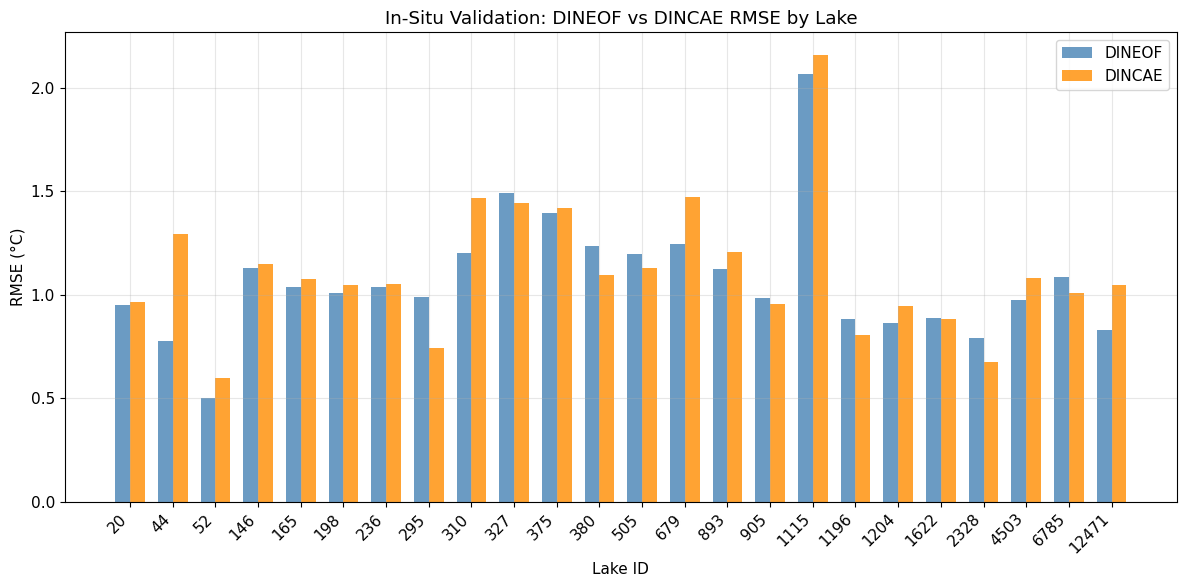

In [9]:
# Filter to reconstruction and main methods
recon = df[(df['data_type'] == 'reconstruction') & 
           (df['method'].isin(['dineof', 'dincae']))].copy()

if not recon.empty:
    # Pivot for plotting
    pivot = recon.pivot_table(
        index='lake_id', 
        columns='method', 
        values='rmse',
        aggfunc='mean'
    ).reset_index().sort_values('lake_id')
    
    n_lakes = len(pivot)
    fig_width = max(12, n_lakes * 0.4)
    
    fig, ax = plt.subplots(figsize=(fig_width, 6))
    
    x = np.arange(n_lakes)
    width = 0.35
    
    if 'dineof' in pivot.columns:
        ax.bar(x - width/2, pivot['dineof'], width, label='DINEOF', color='steelblue', alpha=0.8)
    if 'dincae' in pivot.columns:
        ax.bar(x + width/2, pivot['dincae'], width, label='DINCAE', color='darkorange', alpha=0.8)
    
    ax.set_xlabel('Lake ID')
    ax.set_ylabel('RMSE (°C)')
    ax.set_title('In-Situ Validation: DINEOF vs DINCAE RMSE by Lake')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{int(lid)}" for lid in pivot['lake_id']], rotation=45, ha='right')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'rmse_comparison_by_lake.png'), dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No data for RMSE comparison plot")

### 7.2 RMSE vs Correlation Scatter Plot

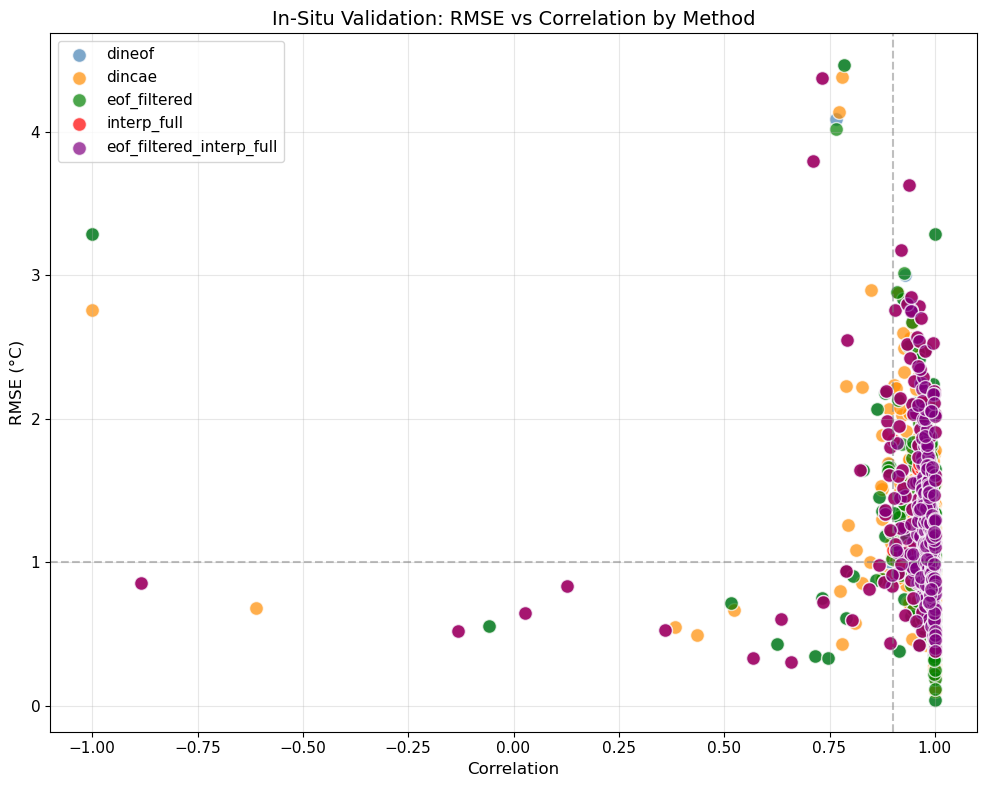

In [10]:
recon = df[df['data_type'] == 'reconstruction'].copy()

if not recon.empty:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    colors = {
        'dineof': 'steelblue',
        'dincae': 'darkorange',
        'eof_filtered': 'green',
        'interp_full': 'red',
        'eof_filtered_interp_full': 'purple'
    }
    
    for method in recon['method'].unique():
        method_data = recon[recon['method'] == method]
        ax.scatter(
            method_data['correlation'], 
            method_data['rmse'],
            c=colors.get(method, 'gray'),
            label=method,
            alpha=0.7,
            s=100,
            edgecolors='white'
        )
    
    ax.set_xlabel('Correlation', fontsize=12)
    ax.set_ylabel('RMSE (°C)', fontsize=12)
    ax.set_title('In-Situ Validation: RMSE vs Correlation by Method', fontsize=14)
    ax.legend(loc='upper left')
    
    # Reference lines
    ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=0.9, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'rmse_vs_correlation.png'), dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No data for scatter plot")

### 7.3 Metrics Box Plots by Method

/tmp/ipykernel_2170/3145847226.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = axes[0].boxplot(data_rmse, labels=methods_present, patch_artist=True)
/tmp/ipykernel_2170/3145847226.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = axes[1].boxplot(data_mae, labels=methods_present, patch_artist=True)
/tmp/ipykernel_2170/3145847226.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp3 = axes[2].boxplot(data_corr, labels=methods_present, patch_artist=True)


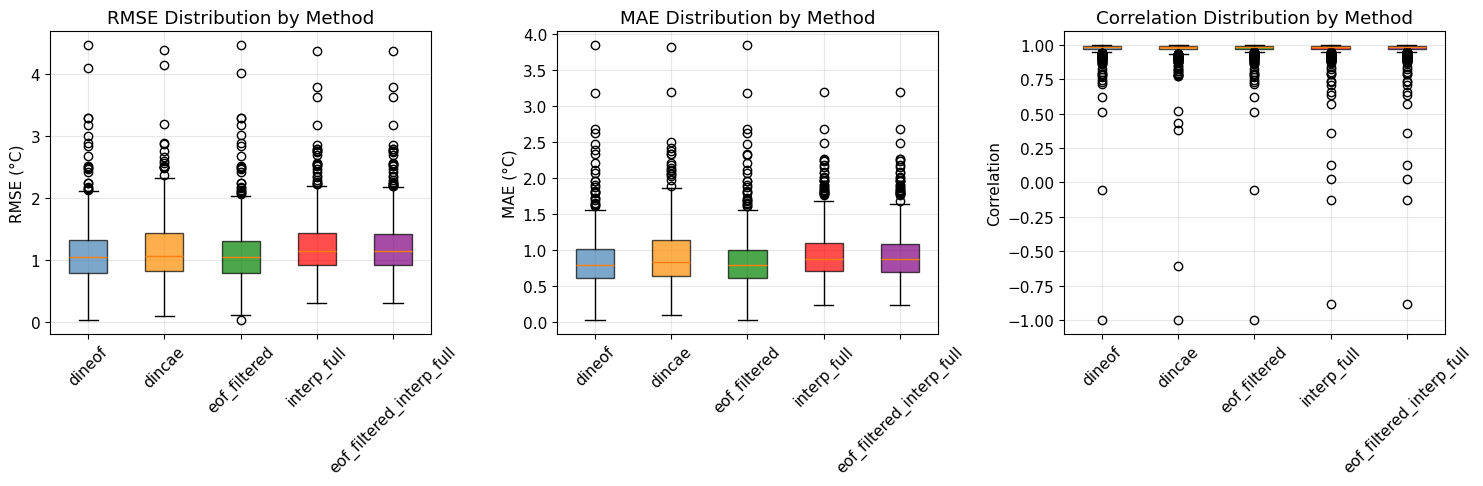

In [11]:
recon = df[df['data_type'] == 'reconstruction'].copy()

if not recon.empty:
    method_order = ['dineof', 'dincae', 'eof_filtered', 'interp_full', 'eof_filtered_interp_full']
    methods_present = [m for m in method_order if m in recon['method'].unique()]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    colors = ['steelblue', 'darkorange', 'green', 'red', 'purple']
    
    # RMSE
    data_rmse = [recon[recon['method'] == m]['rmse'].dropna() for m in methods_present]
    bp1 = axes[0].boxplot(data_rmse, labels=methods_present, patch_artist=True)
    axes[0].set_ylabel('RMSE (°C)')
    axes[0].set_title('RMSE Distribution by Method')
    axes[0].tick_params(axis='x', rotation=45)
    
    # MAE
    data_mae = [recon[recon['method'] == m]['mae'].dropna() for m in methods_present]
    bp2 = axes[1].boxplot(data_mae, labels=methods_present, patch_artist=True)
    axes[1].set_ylabel('MAE (°C)')
    axes[1].set_title('MAE Distribution by Method')
    axes[1].tick_params(axis='x', rotation=45)
    
    # Correlation
    data_corr = [recon[recon['method'] == m]['correlation'].dropna() for m in methods_present]
    bp3 = axes[2].boxplot(data_corr, labels=methods_present, patch_artist=True)
    axes[2].set_ylabel('Correlation')
    axes[2].set_title('Correlation Distribution by Method')
    axes[2].tick_params(axis='x', rotation=45)
    
    # Color boxes
    for bp in [bp1, bp2, bp3]:
        for patch, color in zip(bp['boxes'], colors[:len(methods_present)]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'metrics_boxplot.png'), dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No data for box plots")

### 7.4 RMSE Heatmap (Lakes × Methods)

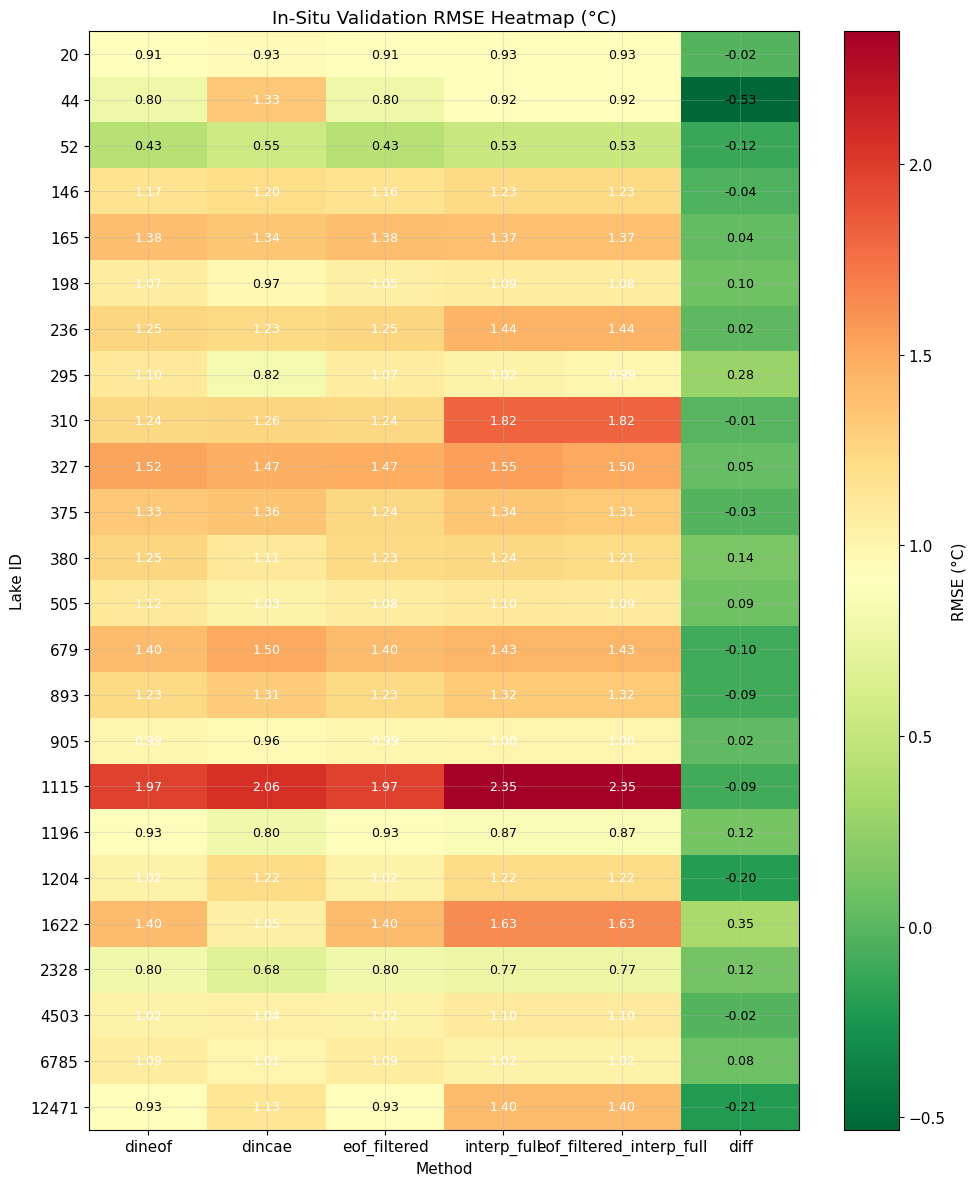

In [12]:
rmse_cols = [c for c in summary.columns if c.startswith('rmse_')]

if rmse_cols and len(summary) > 0:
    matrix = summary[['lake_id'] + rmse_cols].set_index('lake_id')
    matrix.columns = [c.replace('rmse_', '') for c in matrix.columns]
    
    fig, ax = plt.subplots(figsize=(10, max(6, len(matrix) * 0.5)))
    
    im = ax.imshow(matrix.values, cmap='RdYlGn_r', aspect='auto')
    
    ax.set_xticks(np.arange(len(matrix.columns)))
    ax.set_yticks(np.arange(len(matrix)))
    ax.set_xticklabels(matrix.columns)
    ax.set_yticklabels([f"{int(lid)}" for lid in matrix.index])
    
    ax.set_xlabel('Method')
    ax.set_ylabel('Lake ID')
    ax.set_title('In-Situ Validation RMSE Heatmap (°C)')
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('RMSE (°C)')
    
    # Add text annotations
    valid_vals = matrix.values[~np.isnan(matrix.values)]
    if len(valid_vals) > 0:
        mean_val = valid_vals.mean()
        for i in range(len(matrix)):
            for j in range(len(matrix.columns)):
                val = matrix.iloc[i, j]
                if not np.isnan(val):
                    text_color = 'white' if val > mean_val else 'black'
                    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color=text_color, fontsize=9)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'rmse_heatmap.png'), dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No data for heatmap")

### 7.5 Method Comparison Summary (Pie Chart + Histogram)

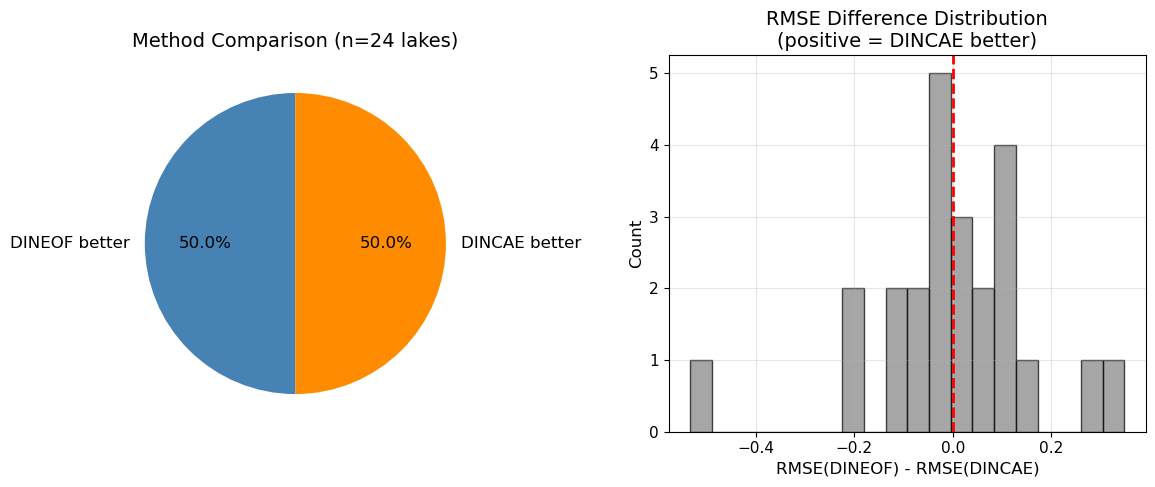

In [13]:
if 'dincae_better' in summary.columns:
    valid = summary.dropna(subset=['rmse_dineof', 'rmse_dincae'])
    
    if len(valid) > 0:
        n_dincae_wins = valid['dincae_better'].sum()
        n_dineof_wins = len(valid) - n_dincae_wins
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Pie chart
        axes[0].pie(
            [n_dineof_wins, n_dincae_wins],
            labels=['DINEOF better', 'DINCAE better'],
            colors=['steelblue', 'darkorange'],
            autopct='%1.1f%%',
            startangle=90,
            textprops={'fontsize': 12}
        )
        axes[0].set_title(f'Method Comparison (n={len(valid)} lakes)', fontsize=14)
        
        # RMSE difference histogram
        rmse_diff = valid['rmse_diff']
        axes[1].hist(rmse_diff, bins=20, color='gray', edgecolor='black', alpha=0.7)
        axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
        axes[1].set_xlabel('RMSE(DINEOF) - RMSE(DINCAE)', fontsize=12)
        axes[1].set_ylabel('Count', fontsize=12)
        axes[1].set_title('RMSE Difference Distribution\n(positive = DINCAE better)', fontsize=14)
        
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, 'method_comparison_summary.png'), dpi=150, bbox_inches='tight')
        plt.show()
    else:
        print("No data for comparison plot")
else:
    print("No comparison data available")

### 7.6 Detailed Lake-by-Lake Comparison Table

In [14]:
# Create a styled comparison table
if 'rmse_dineof' in summary.columns and 'rmse_dincae' in summary.columns:
    comparison = summary[['lake_id', 'rmse_dineof', 'rmse_dincae', 'rmse_diff', 'dincae_better',
                          'corr_dineof', 'corr_dincae', 'n_dineof', 'n_dincae']].copy()
    comparison = comparison.dropna(subset=['rmse_dineof', 'rmse_dincae'])
    comparison = comparison.sort_values('rmse_diff', ascending=False)  # DINCAE wins at top
    
    # Round for display
    comparison['rmse_dineof'] = comparison['rmse_dineof'].round(3)
    comparison['rmse_dincae'] = comparison['rmse_dincae'].round(3)
    comparison['rmse_diff'] = comparison['rmse_diff'].round(4)
    comparison['corr_dineof'] = comparison['corr_dineof'].round(3)
    comparison['corr_dincae'] = comparison['corr_dincae'].round(3)
    comparison['winner'] = comparison['dincae_better'].map({True: 'DINCAE', False: 'DINEOF'})
    
    display(comparison.drop(columns=['dincae_better']))
else:
    print("Comparison data not available")

,lake_id,rmse_dineof,rmse_dincae,rmse_diff,corr_dineof,corr_dincae,n_dineof,n_dincae,winner
22,1622,1.399,1.051,0.3483,0.983,0.989,19,19,DINCAE
7,295,1.099,0.820,0.2792,0.968,0.977,167,167,DINCAE
11,380,1.246,1.107,0.1389,0.977,0.981,428,428,DINCAE
17,1196,0.926,0.804,0.1226,0.984,0.987,92,92,DINCAE
23,2328,0.797,0.677,0.1202,0.986,0.989,164,164,DINCAE
5,198,1.069,0.972,0.0973,0.981,0.980,1102,1102,DINCAE
12,505,1.118,1.025,0.0928,0.982,0.983,72,72,DINCAE
20,6785,1.086,1.009,0.0770,0.988,0.989,1914,1914,DINCAE
9,327,1.522,1.471,0.0512,0.976,0.974,208,208,DINCAE
4,165,1.382,1.345,0.0368,0.945,0.945,343,343,DINCAE


## 8. Interactive Exploration

In [15]:
# Explore data for a specific lake
def show_lake_details(lake_id):
    """Show all in-situ validation data for a specific lake."""
    lake_data = df[df['lake_id'] == lake_id]
    if lake_data.empty:
        print(f"No data for lake {lake_id}")
        return
    
    print(f"\n{'='*60}")
    print(f"Lake {lake_id} - In-Situ Validation Results")
    print(f"{'='*60}")
    
    # Show reconstruction results
    recon = lake_data[lake_data['data_type'] == 'reconstruction']
    if not recon.empty:
        print("\nReconstruction:")
        print(recon[['method', 'n_matches', 'rmse', 'mae', 'bias', 'correlation']].to_string(index=False))
    
    # Show observation results
    obs = lake_data[lake_data['data_type'] == 'observation']
    if not obs.empty:
        print("\nObservation (original sparse data):")
        print(obs[['method', 'n_matches', 'rmse', 'mae', 'bias', 'correlation']].to_string(index=False))

# Example: Show details for lake 20
if len(df) > 0:
    example_lake = int(df['lake_id'].iloc[0])
    show_lake_details(example_lake)


Lake 20 - In-Situ Validation Results

Reconstruction:
                  method  n_matches     rmse      mae      bias  correlation
                  dineof        409 0.908695 0.759400 -0.622124     0.918630
                  dincae        409 0.931527 0.764378 -0.638993     0.919676
            eof_filtered        409 0.908697 0.759402 -0.622126     0.918630
             interp_full        561 0.927332 0.761268 -0.637014     0.911359
eof_filtered_interp_full        561 0.927332 0.761268 -0.637014     0.911359
                  dineof         57 0.622688 0.527598 -0.174302     0.943299
                  dineof        173 0.885455 0.719503 -0.546697     0.873623
                  dineof        168 0.975115 0.844520 -0.808136     0.949771
                  dineof         11 1.356503 1.288013 -1.288013     0.873845
                  dincae         57 0.724476 0.588607 -0.348756     0.935442
                  dincae        173 0.908226 0.742519 -0.603765     0.885808
                  din

In [16]:
# List all lakes with in-situ data
print("Lakes with in-situ validation data:")
print(sorted(df['lake_id'].unique().astype(int).tolist()))

Lakes with in-situ validation data:
[20, 44, 52, 146, 165, 198, 236, 295, 310, 327, 375, 380, 505, 679, 893, 905, 1115, 1196, 1204, 1622, 2328, 4503, 6785, 12471]


## 9. Output Summary

In [17]:
print("\n" + "=" * 60)
print("OUTPUT FILES")
print("=" * 60)
print(f"\nDirectory: {OUTPUT_DIR}")
print("\nCSV files:")
print(f"  - insitu_all_results.csv     (all data, {len(df)} rows)")
print(f"  - insitu_summary.csv         (summary, {len(summary)} lakes)")
print("\nPlot files:")
print("  - rmse_comparison_by_lake.png")
print("  - rmse_vs_correlation.png")
print("  - metrics_boxplot.png")
print("  - rmse_heatmap.png")
print("  - method_comparison_summary.png")
print("=" * 60)


OUTPUT FILES

Directory: /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/anomaly-20251215-8ea02d-exp3/insitu_analysis

CSV files:
  - insitu_all_results.csv     (all data, 5076 rows)
  - insitu_summary.csv         (summary, 24 lakes)

Plot files:
  - rmse_comparison_by_lake.png
  - rmse_vs_correlation.png
  - metrics_boxplot.png
  - rmse_heatmap.png
  - method_comparison_summary.png
